# Propmpt chaining work flow

Stock market simple small project using LangGraph.
first **pick 20 macd bullish stocks** based on **price limit filter** it then apply **fundamental anaysis** on it.

In [6]:
#stock matket small project using LangGraph and Playwright
!pip install langgraph
!pip install playwright
!playwright install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 19.3 MB/s eta 0:00:00
173.7 MiB [] 0% 0.0s173.7 MiB [] 0% 7.3s173.7 MiB [] 0% 3.5s173.7 MiB [] 1% 3.1s173.7 MiB [] 2% 3.1s173.7 MiB [] 3% 2.8s173.7 MiB [] 4% 2.8s173.7 MiB [] 5% 3.0s173.7 MiB [] 5% 3.1s173.7 MiB [] 6% 3.1s173.7 MiB [] 6% 3.2s173.7 MiB [] 7% 3.2s173.7 MiB [] 8% 3.0s173.7 MiB [] 9% 3.0s173.7 MiB [] 10% 3.0s173.7 MiB [] 11% 2.9s173.7 MiB [] 11% 2.8s173.7 MiB [] 12% 2.7s173.7 MiB [] 12% 2.8s173.7 MiB [] 13% 2.8s173.7 MiB [] 13% 2.7s173.7 MiB [] 14% 2.7s173.7 MiB [] 15% 2.7s173.7 MiB [] 15% 2.6s173.7 MiB [] 16% 2.5s173.7 MiB [] 17% 2.5s173.7 MiB [] 18% 2.4s173.7 MiB [] 20% 2.3s173.7 MiB [] 21% 2.2s173.7 MiB

In [1]:
import asyncio
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
from langgraph.graph import StateGraph , START , END
from typing import TypedDict

In [2]:
class StocksState(TypedDict):
    stock_names: list[str]
    stock_tickers: list[str]
    stock_prices: list[float]
    stock_fundamental_analysis: list[bool]
    stock_RSI_indication : list[bool]
    stock_Boilinger_Bands_indication : list[bool]
    stock_lower_price_limit : int
    stock_upper_price_limit : int

In [3]:
import asyncio
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup

async def bullish_macd_20_pick(state):
    """
    Compatible with synchronous LangGraph nodes.
    Fetches MACD crossover stocks from ChartInk.
    """

    # Ensure the state has required attributes (works with StocksState dataclass)
    # if not state.get("stock_names"):
    state["stock_names"] = []
    # if not state.get("stock_tickers"):
    #     state["stock_tickers"] = []
    # if not state.get("stock_prices"):
    #     state["stock_prices"] = []

    try:
        async with async_playwright() as p:
            browser = await p.chromium.launch(headless=True)
            page = await browser.new_page()
            url = "https://chartink.com/screener/macd-crossover-bearish-bullish"
            await page.goto(url, timeout=60000)
            print("✅ Page loaded... waiting for table...")
            await page.wait_for_selector("table tr a", timeout=60000)
            html = await page.content()
            await browser.close()

        # Parse HTML with BeautifulSoup
        soup = BeautifulSoup(html, "html.parser")
        rows = soup.select("tbody tr")

        for row in rows:
            cols = row.select("td")
            if len(cols) >= 6:
                name = cols[1].text.strip()
                ticker = cols[2].text.strip()
                try:
                    price = float(cols[5].text.strip().replace(",", ""))
                except ValueError:
                    price = None

                state["stock_names"].append(name)
                state["stock_tickers"].append(ticker)
                state["stock_prices"].append(price)

        print(f"✅ Extracted {len(state['stock_names'])} stocks.")

    except Exception as e:
        print(f"⚠️ Error fetching data: {e}")
    print(state)
    return state

In [4]:
def price_filter(state : StocksState) -> StocksState:
    """
    Filters stocks based on price criteria.
    Keeps stocks with price between 100 and 500.
    """
    filtered_names = []
    filtered_tickers = []
    filtered_prices = []

    print("state..................state.........")
    print(state["stock_lower_price_limit"])

    lower_limit = state["stock_lower_price_limit"]
    upper_limit = state["stock_upper_price_limit"]

    print(state["stock_tickers"])

    for name, ticker, price in zip(state["stock_names"], state["stock_tickers"], state["stock_prices"]):
        if lower_limit <= price <= upper_limit:#price criteria variable
            filtered_names.append(name)
            filtered_tickers.append(ticker)
            filtered_prices.append(price)

    state["stock_names"] = filtered_names
    state["stock_tickers"] = filtered_tickers
    state["stock_prices"] = filtered_prices

    return state

In [5]:
import yfinance as yf

def fundamental_analysis(state : StocksState) -> StocksState:

    fundamentals = []
    for s in state['stock_tickers']:
        s = s + '.NS'
        stock = yf.Ticker(s)
        info = stock.info

        current_price = info.get('currentPrice') or info.get('regularMarketPrice')
        pb_ratio = info.get('priceToBook')
        debt_to_equity = info.get('debtToEquity')
        eps = info.get('trailingEps')
        roe = info.get('returnOnEquity')

        print(f"=====stock: {s}====")
        print(f"current_price: {current_price}")
        print(f"pb_ratio: {pb_ratio}")
        print(f"debt_to_equity: {debt_to_equity}")
        print(f"eps: {eps}")
        print(f"roe: {roe}")
        print("/n/n")

        if debt_to_equity is not None and debt_to_equity > 1:
            debt_to_equity = debt_to_equity / 100

        conditions = {
            # "PE < Industry PE": pe_ratio is not None and industry_pe is not None and pe_ratio < industry_pe,
            "Debt/Equity < 0.5": debt_to_equity is not None and debt_to_equity < 0.5,
            "PB < 10": pb_ratio is not None and pb_ratio < 10,
            "EPS > 0.1×Price": eps is not None and current_price is not None and eps > 0.1 * current_price,
            "ROE > 12%": roe is not None and roe > 0.12
        }

        met = sum(conditions.values())
        signal = True if met >= 3 else False
        fundamentals.append(signal)


    state['stock_fundamental_analysis'] = fundamentals
    return state

In [6]:
graph = StateGraph(StocksState)

#add nodes
graph.add_node("bullish macd 20 pick", bullish_macd_20_pick)
graph.add_node("price filter", price_filter)
graph.add_node("fundamental analysis", fundamental_analysis) #to be implemented

#define edges
graph.add_edge(START , 'bullish macd 20 pick')
graph.add_edge('bullish macd 20 pick','price filter')
graph.add_edge('price filter','fundamental analysis')
graph.add_edge('fundamental analysis',END)

#compile
workflow = graph.compile()

In [46]:
inital_state = {'stock_lower_price_limit':1 , 'stock_upper_price_limit':1000 , 'stock_names' : [] , 'stock_tickers' : [] , 'stock_prices' : [] }
# final_state = workflow.invoke(inital_state)
# final_state =  workflow.invoke(inital_state)

async for state in workflow.astream(inital_state):
    print(state)

✅ Page loaded... waiting for table...
✅ Extracted 20 stocks.
{'stock_names': ['Raj Oil Mills Ltd', 'G-Tec Janix Education Ltd', 'Jayaswal Neco Industries Limited', 'Aro Granite Industries Limited', 'Paras Defence and Space Technologies Ltd', 'Hardwyn India Ltd', '3i Infotech Ltd', 'Norben Tea & Exports Limited', 'Future Supply Chain Solutions Ltd', 'Consolidated Finvest & Holdings Limited', 'Suven Life Sciences Limited', 'Schneider Electric Infrastructure Limited', 'Kamdhenu Limited', 'Sanwaria Agro Oils Limited', 'Navkar Corporation Limited', 'Fischer Medical Ventures Ltd', 'Vedanta Limited', 'Beml Limited', 'Touchwood Entertainment Ltd', 'Intrasoft Technologies Limited'], 'stock_tickers': ['ROML', 'GTECJAINX', 'JAYNECOIND', 'AROGRANITE', 'PARAS', 'HARDWYN', '3IINFOLTD', 'NORBTEAEXP', 'FSC', 'CONSOFINVT', 'SUVEN', 'SCHNEIDER', 'KAMDHENU', 'SANWARIA', 'NAVKARCORP', 'FISCHER', 'VEDL', 'BEML', 'TOUCHWOOD', 'ISFT'], 'stock_prices': [58.02, 27.8, 78.57, 38.06, 755.55, 14.07, 20.32, 57.44, 

In [43]:
# SCHNEIDER
import yfinance as yf
data = yf.Ticker("SCHNEIDER.NS")
print(data.info)

{'address1': 'Tower C', 'address2': '9th Floor DLF Building No. 10 DLF Cyber City, Phase II', 'city': 'Gurugram', 'zip': '122002', 'country': 'India', 'phone': '91 12 4715 2300', 'fax': '91 12 4422 2036', 'website': 'https://infra-in.se.com', 'industry': 'Electrical Equipment & Parts', 'industryKey': 'electrical-equipment-parts', 'industryDisp': 'Electrical Equipment & Parts', 'sector': 'Industrials', 'sectorKey': 'industrials', 'sectorDisp': 'Industrials', 'longBusinessSummary': 'Schneider Electric Infrastructure Limited designs, manufactures, builds, and services products and systems for electricity distribution in India and internationally. The company offers medium power, distribution, and special transformers; substation automation systems, including power management systems, controllers and RTUs, communication elements, graphic user interfaces, engineering tools, SCADA and EMS gateways, and simulation tools; and ring main units. It also offers medium voltage distribution and grid

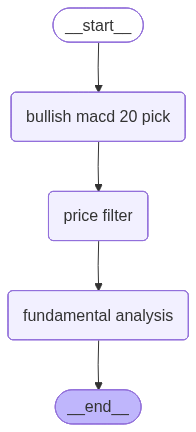

In [7]:
from IPython.display import Image

Image(workflow.get_graph().draw_mermaid_png())